# Comparação de Estratégias de Seleção de Instâncias em Aprendizado Ativo

## Imports

In [1]:
import os

import pandas as pd
import numpy as np

## Reunindo Resultados para Comparação

In [2]:
RESULTS_DIR = '../../scripts/results/'

Por hora, seram analisados apenas as queries que utilizaram um determinado algoritmo (KNN) como aprendiz

## Definições

In [3]:
def gen_auc_df(file):
    auc_dict = dict()
    results = pd.read_csv(file)
    strategies = [c for c in results.columns if not 'choice' in c and not 'Unnamed' in c]
    
    for s in strategies:
        auc_dict[s] = [np.trapz(results[s][:i+1]) for i in range(len(results[s]))]
    auc_df = pd.DataFrame(auc_dict)
    
    return auc_df.sub(auc_df.random_meta_sampling, axis=0)

        

In [4]:
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

styles = ['X-', 's-', '^-', 'v-', 'D-', 'P-', '+-', '*-', '--', 'x-']

def display_graph(df,i, total, file ):
    df.plot(grid=True, figsize=(16, 6),
            title=f'Ganho F1-macro X Query ({file if file else "Medio"}) [{i+1}/{total}]',
            style=styles, alpha=0.5 )
    
def display_all_graphs(learner_result_files):

    for i, f in enumerate(learner_result_files):
        auc_df = gen_auc_df(f)

        display_graph(auc_df, i, len(learner_result_files), f)
        
        display(plt.gcf())
    
        if (input('Pressione Enter para continuar...')) == 'q':
            break
    
        clear_output(wait=True)
        
        plt.close()
    plt.close()

In [32]:
def summary_graph(learner_result_files, ax, title):
    
    mean_dict, std_dict = dict(), dict()
    df_list = []
    for f in learner_result_files:
        df_list.append(gen_auc_df(f))

    strategies = df_list[0].columns

    for s in strategies:
        df = pd.concat([e[s] for e in  df_list], axis=1)
        mean_dict[s] = df.mean(axis=1)
        std_dict[s] = df.std(axis=1)


    pd.DataFrame(mean_dict).plot(grid=True, style=styles, alpha=0.5, ax=ax, sharey=True, title=title)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heat_maps(result_files):
    df = pd.concat([pd.read_csv(f, index_col=0).filter(like='choice') for f in result_files], axis=1)
    df.fillna('NaN', inplace=True)
    value_to_int = {j:i for i, j in enumerate(sorted(pd.unique(df.values.ravel()), reverse=True))}

    
    fig, axs = plt.subplots(1,2)
    fig.set_size_inches(40,20)
    plot_heat_map(df['meta_sampling_choice'], axs[0], 'Meta-sampling', result_files, value_to_int)
    plot_heat_map(df['perfect_sampling_choice'], axs[1], 'Perfect Meta-sampling', result_files, value_to_int)

    
def plot_heat_map(df, ax, title, result_files, value_to_int):

    cmap = sns.color_palette(n_colors=len(value_to_int))
    
    new_columns = [os.path.basename(f) for f in result_files]
    new_df = df.replace(value_to_int)
    new_df.columns = new_columns
    
    sns.heatmap(new_df.T, linewidth=.1, cmap=cmap,ax=ax, vmin=0, vmax=len(value_to_int))
                                             
    
    colorbar = ax.collections[-1].colorbar 
    n = len(value_to_int)
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(list(value_to_int.keys()))

    ax.set_title(title)

## KNN como Aprendiz 

In [100]:
old_knn_results = !find $RESULTS_DIR -type f | grep 'KNeighborsClassifier_query'
knn_results = !find $RESULTS_DIR -type f | grep 'KNeighborsClassifier_no_query/'

print(f'- {len(old_knn_results)} (query number + unsp. mfts + clst. mfts)')
print(f'- {len(knn_results)} (unsp. mfts + clst. mfts)')

- 89 (query number + unsp. mfts + clst. mfts)
- 101 (unsp. mfts + clst. mfts)


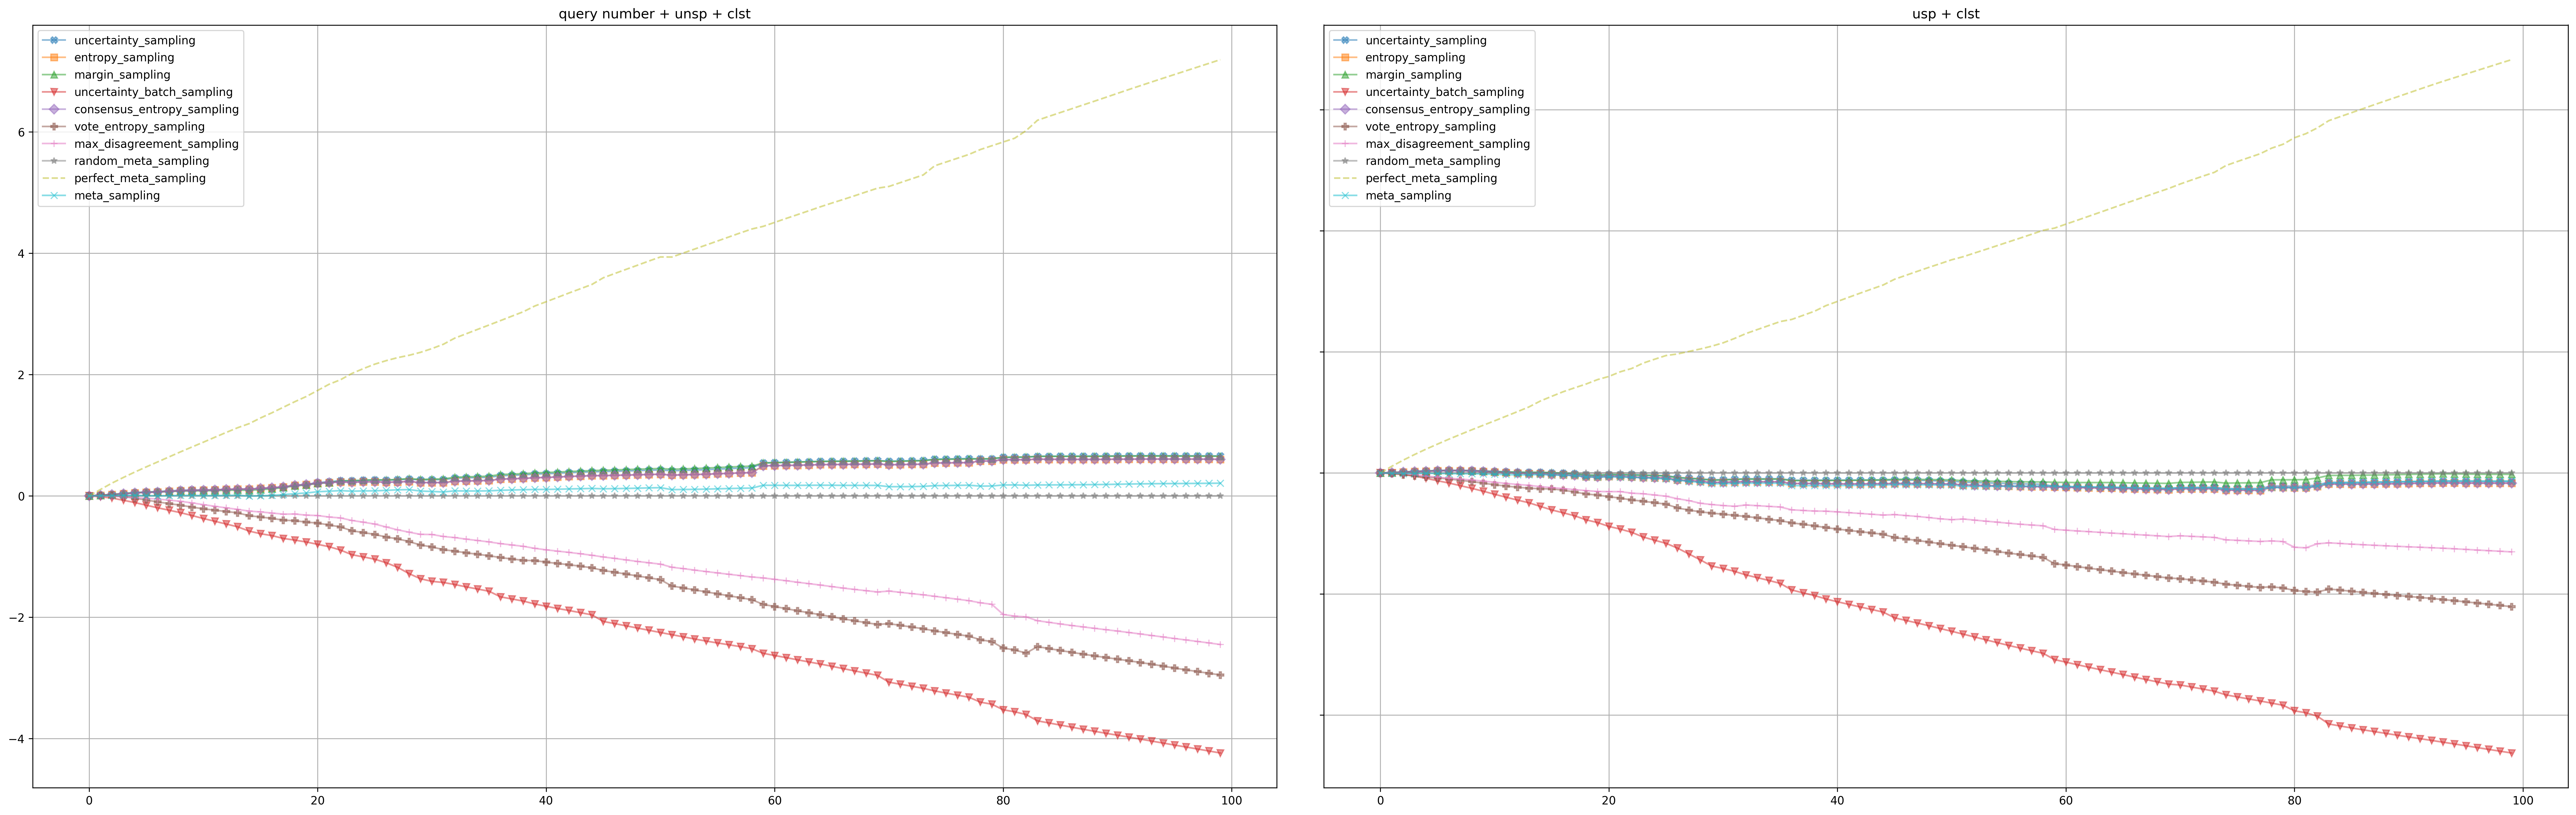

In [101]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(32,10)
fig.set_dpi(300)
fig.tight_layout()
summary_graph(old_knn_results, ax=axs[0], title='query number + unsp + clst')
summary_graph(knn_results, ax=axs[1], title='usp + clst')
plt.show()

#### Gráficos Isolados

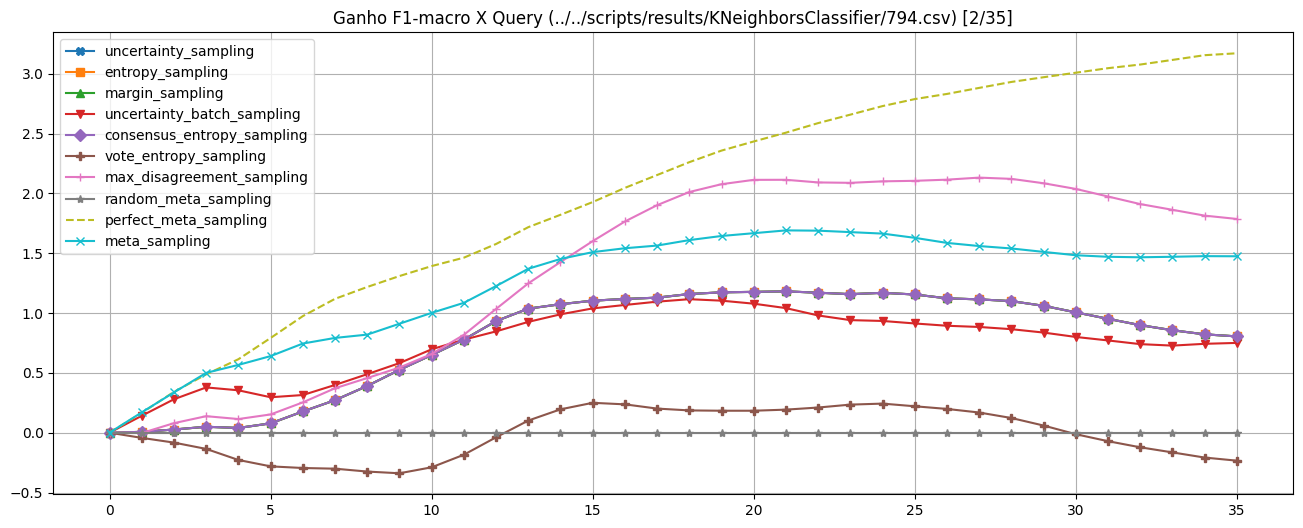

Pressione Enter para continuar... q


In [91]:
display_all_graphs(knn_results)

### Analise Gráfica das Recomendações

#### Unsupervised + Clustering 

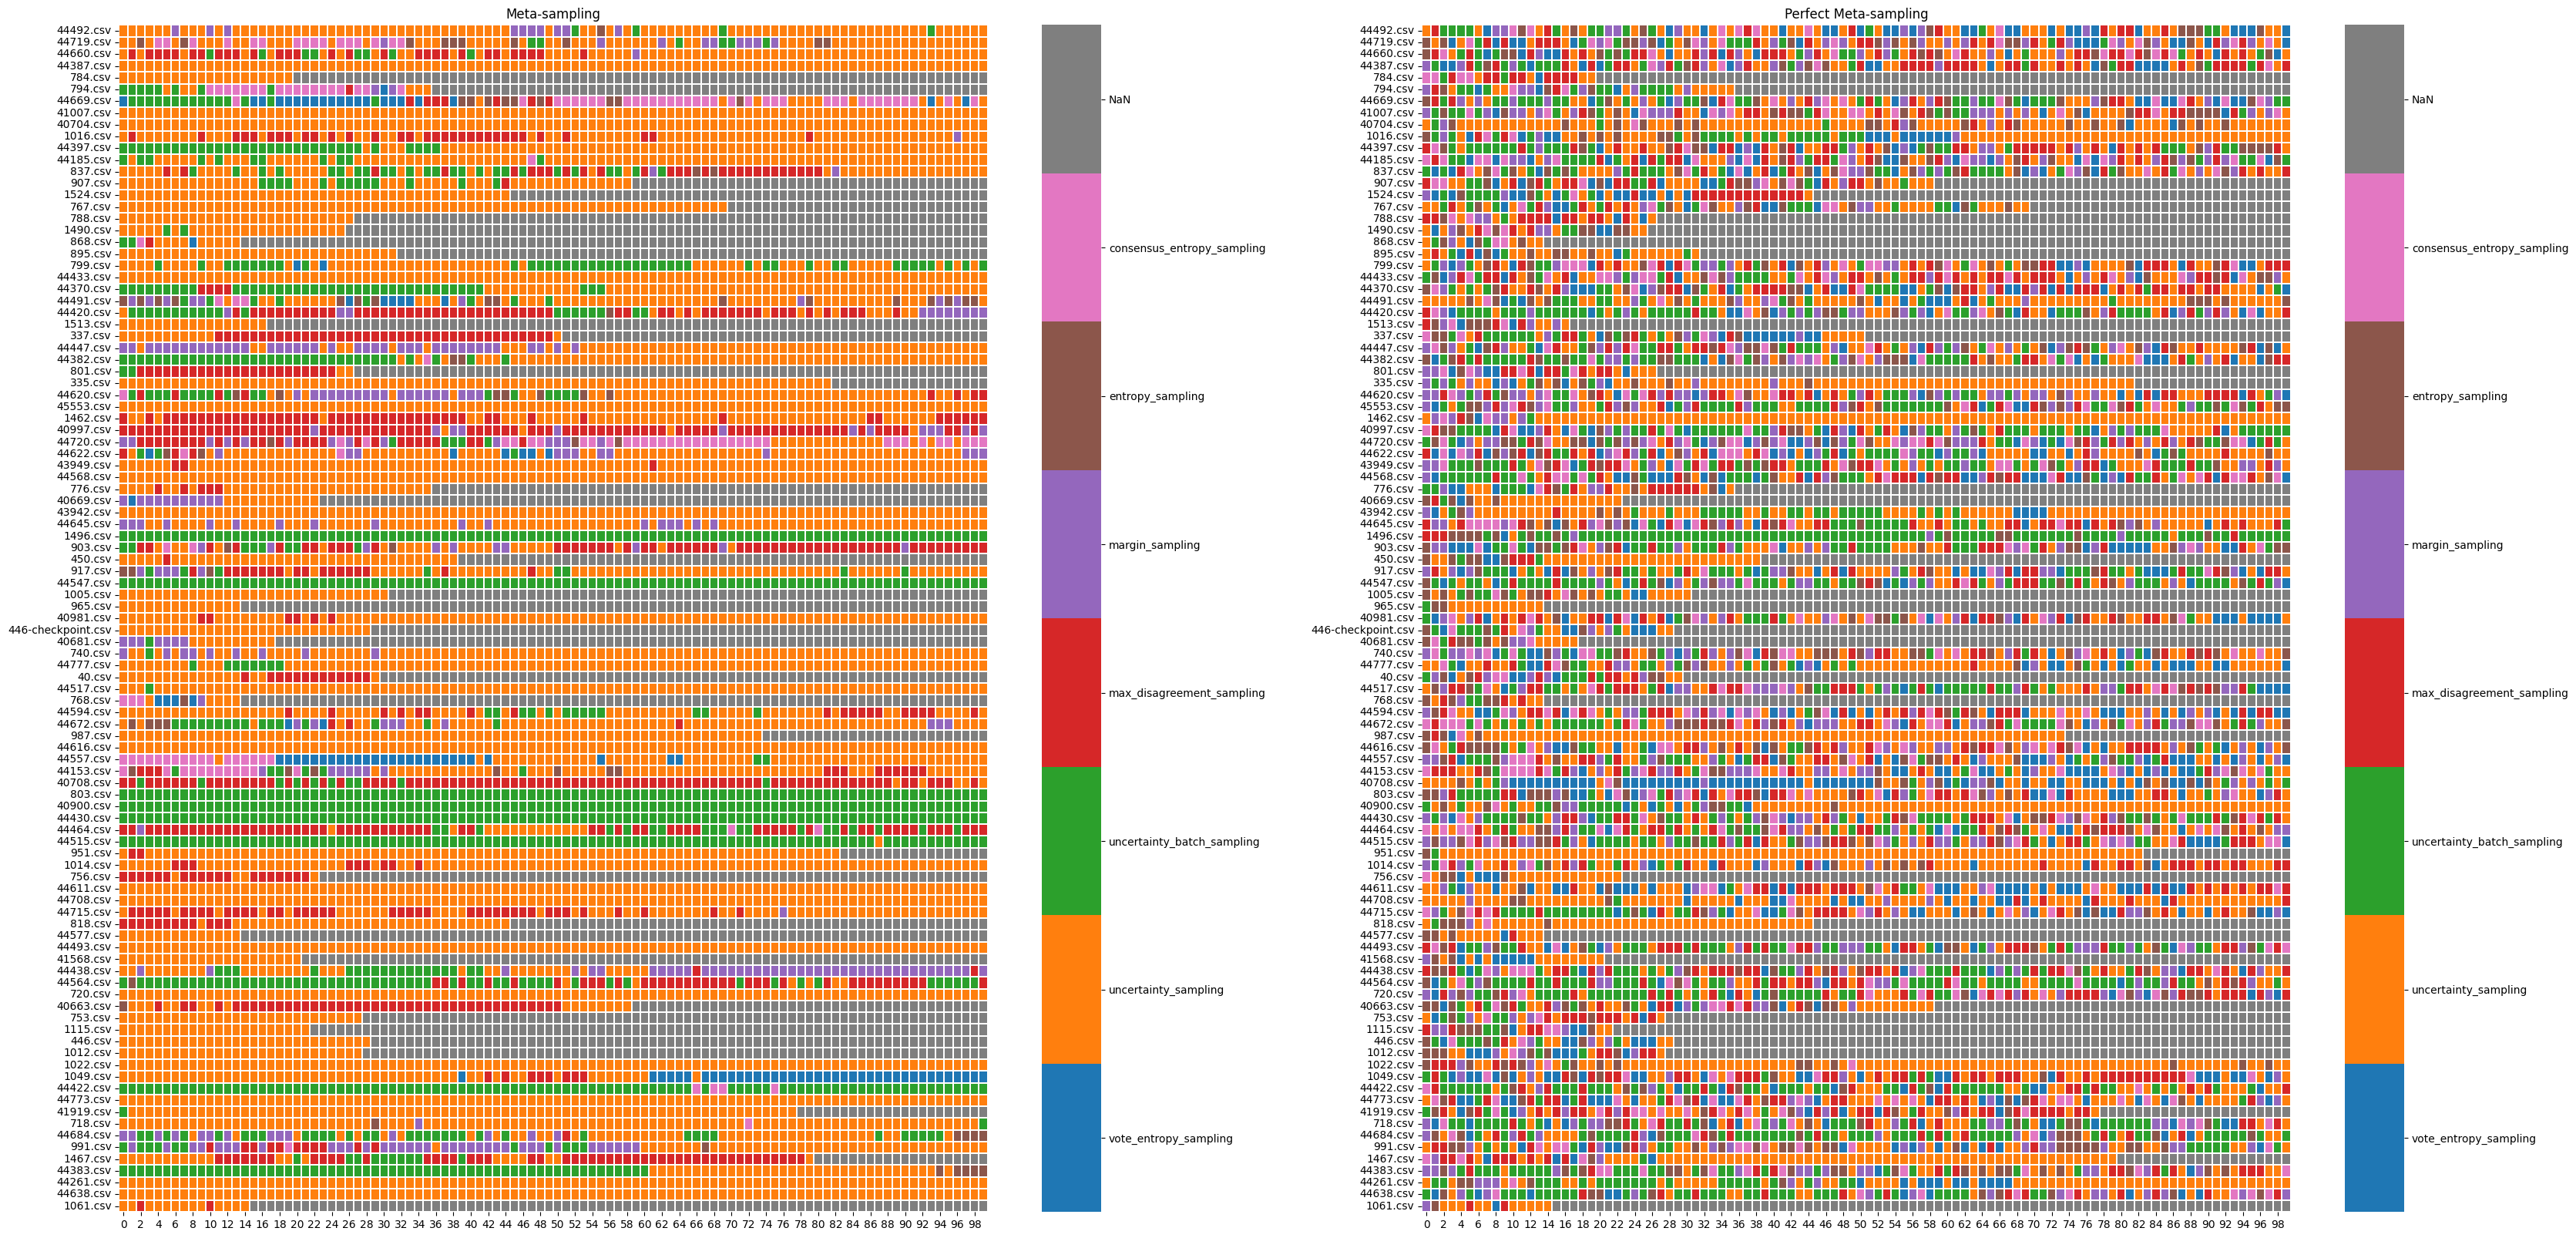

In [39]:
plot_heat_maps(knn_results)

#### Query Number + Unsupervised + Clustering 

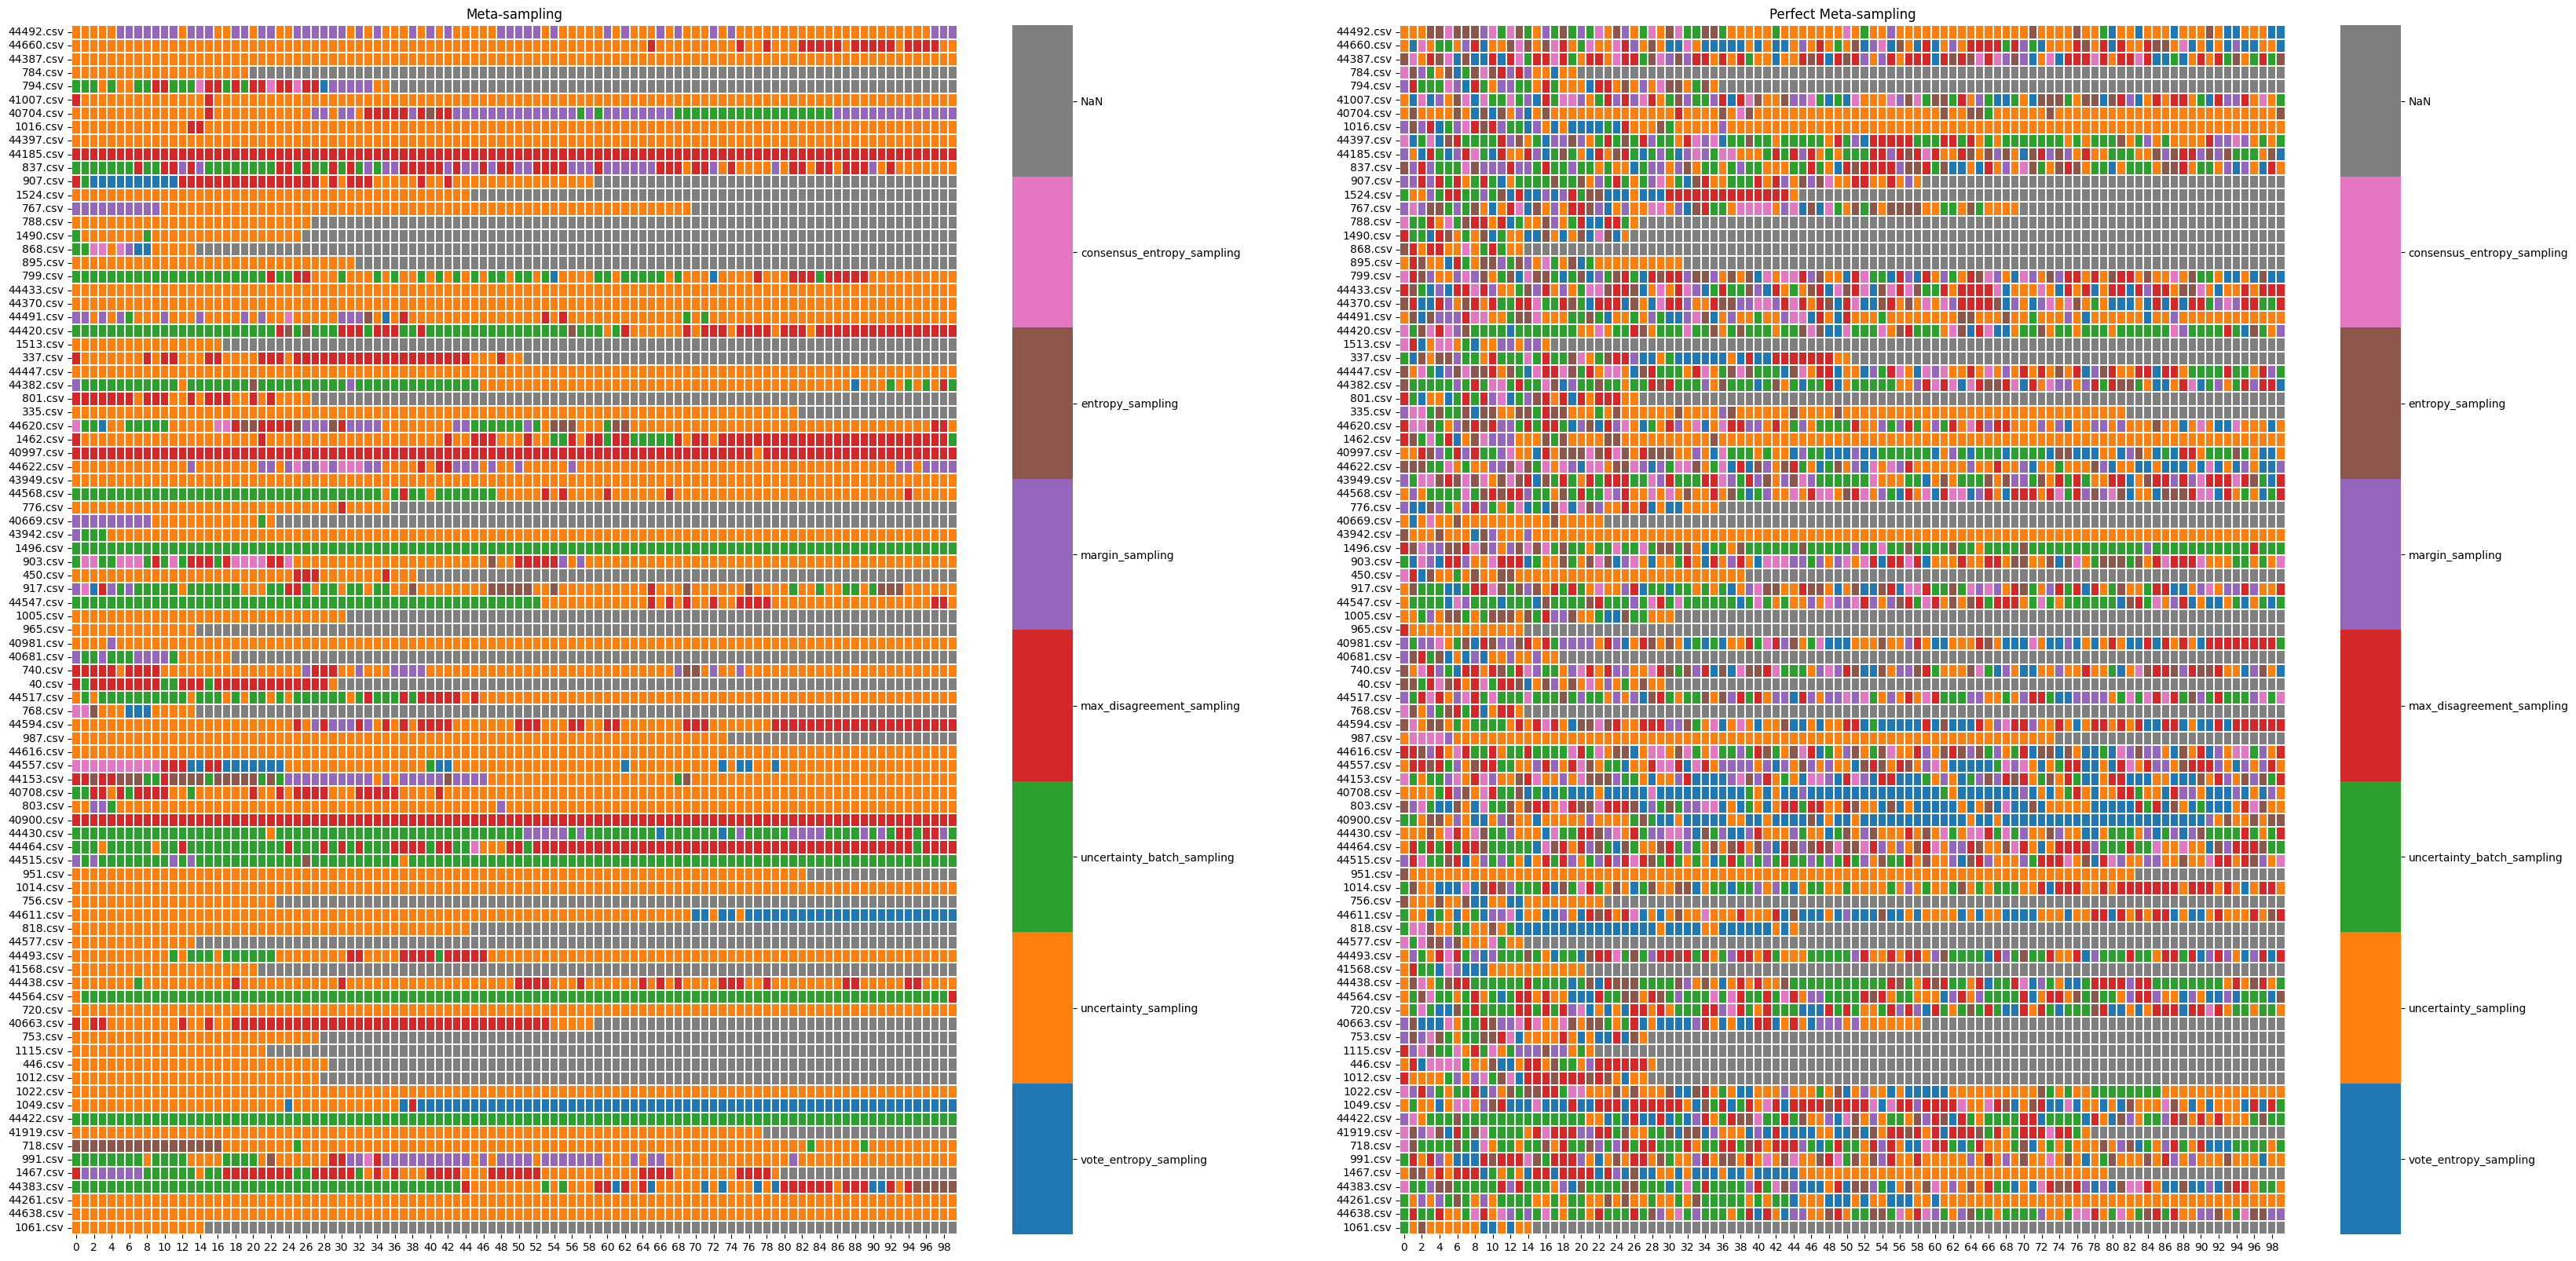

In [40]:
plot_heat_maps(old_knn_results)

### Análise descritiva das recomendações

In [53]:
def describe_results(result_files):
    return  pd.concat(pd.read_csv(f) for f in result_files).filter(like='choice').apply(pd.value_counts).transform(lambda x: x.div(sum(x))).sort_values(by='meta_sampling_choice',ascending=False)

#### Unsupervised + Clustering 

In [54]:
describe_results(knn_results)

random_sampling_choice  perfect_sampling_choice  \
uncertainty_sampling                      0.146830                 0.308330   
uncertainty_batch_sampling                0.141472                 0.179487   
max_disagreement_sampling                 0.137262                 0.140962   
margin_sampling                           0.145682                 0.091083   
consensus_entropy_sampling                0.144406                 0.069652   
vote_entropy_sampling                     0.134966                 0.112769   
entropy_sampling                          0.149381                 0.097717   

                            meta_sampling_choice  
uncertainty_sampling                    0.635413  
uncertainty_batch_sampling              0.164052  
max_disagreement_sampling               0.115831  
margin_sampling                         0.040184  
consensus_entropy_sampling              0.019900  
vote_entropy_sampling                   0.014032  
entropy_sampling                        0.010588

#### Query Number + Unsupervised + Clustering 

In [55]:
describe_results(old_knn_results)

random_sampling_choice  perfect_sampling_choice  \
uncertainty_sampling                      0.145902                 0.310581   
uncertainty_batch_sampling                0.146796                 0.173025   
max_disagreement_sampling                 0.144113                 0.140387   
margin_sampling                           0.147839                 0.083010   
vote_entropy_sampling                     0.146349                 0.127869   
entropy_sampling                          0.129806                 0.100298   
consensus_entropy_sampling                0.139195                 0.064829   

                            meta_sampling_choice  
uncertainty_sampling                    0.638748  
uncertainty_batch_sampling              0.149925  
max_disagreement_sampling               0.132638  
margin_sampling                         0.041282  
vote_entropy_sampling                   0.020715  
entropy_sampling                        0.010581  
consensus_entropy_sampling              0.006110

## SVM como aprendiz

In [84]:
svm_results = !find $RESULTS_DIR -type f | grep 'SVC/'
old_svm_results = !find $RESULTS_DIR -type f | grep 'SVC_'

print(f'- {len(old_svm_results)} (query number + unsp. mfts + clst. mfts)')
print(f'- {len(svm_results)} (unsp. mfts + clst. mfts)')

- 92 (query number + unsp. mfts + clst. mfts)
- 96 (unsp. mfts + clst. mfts)


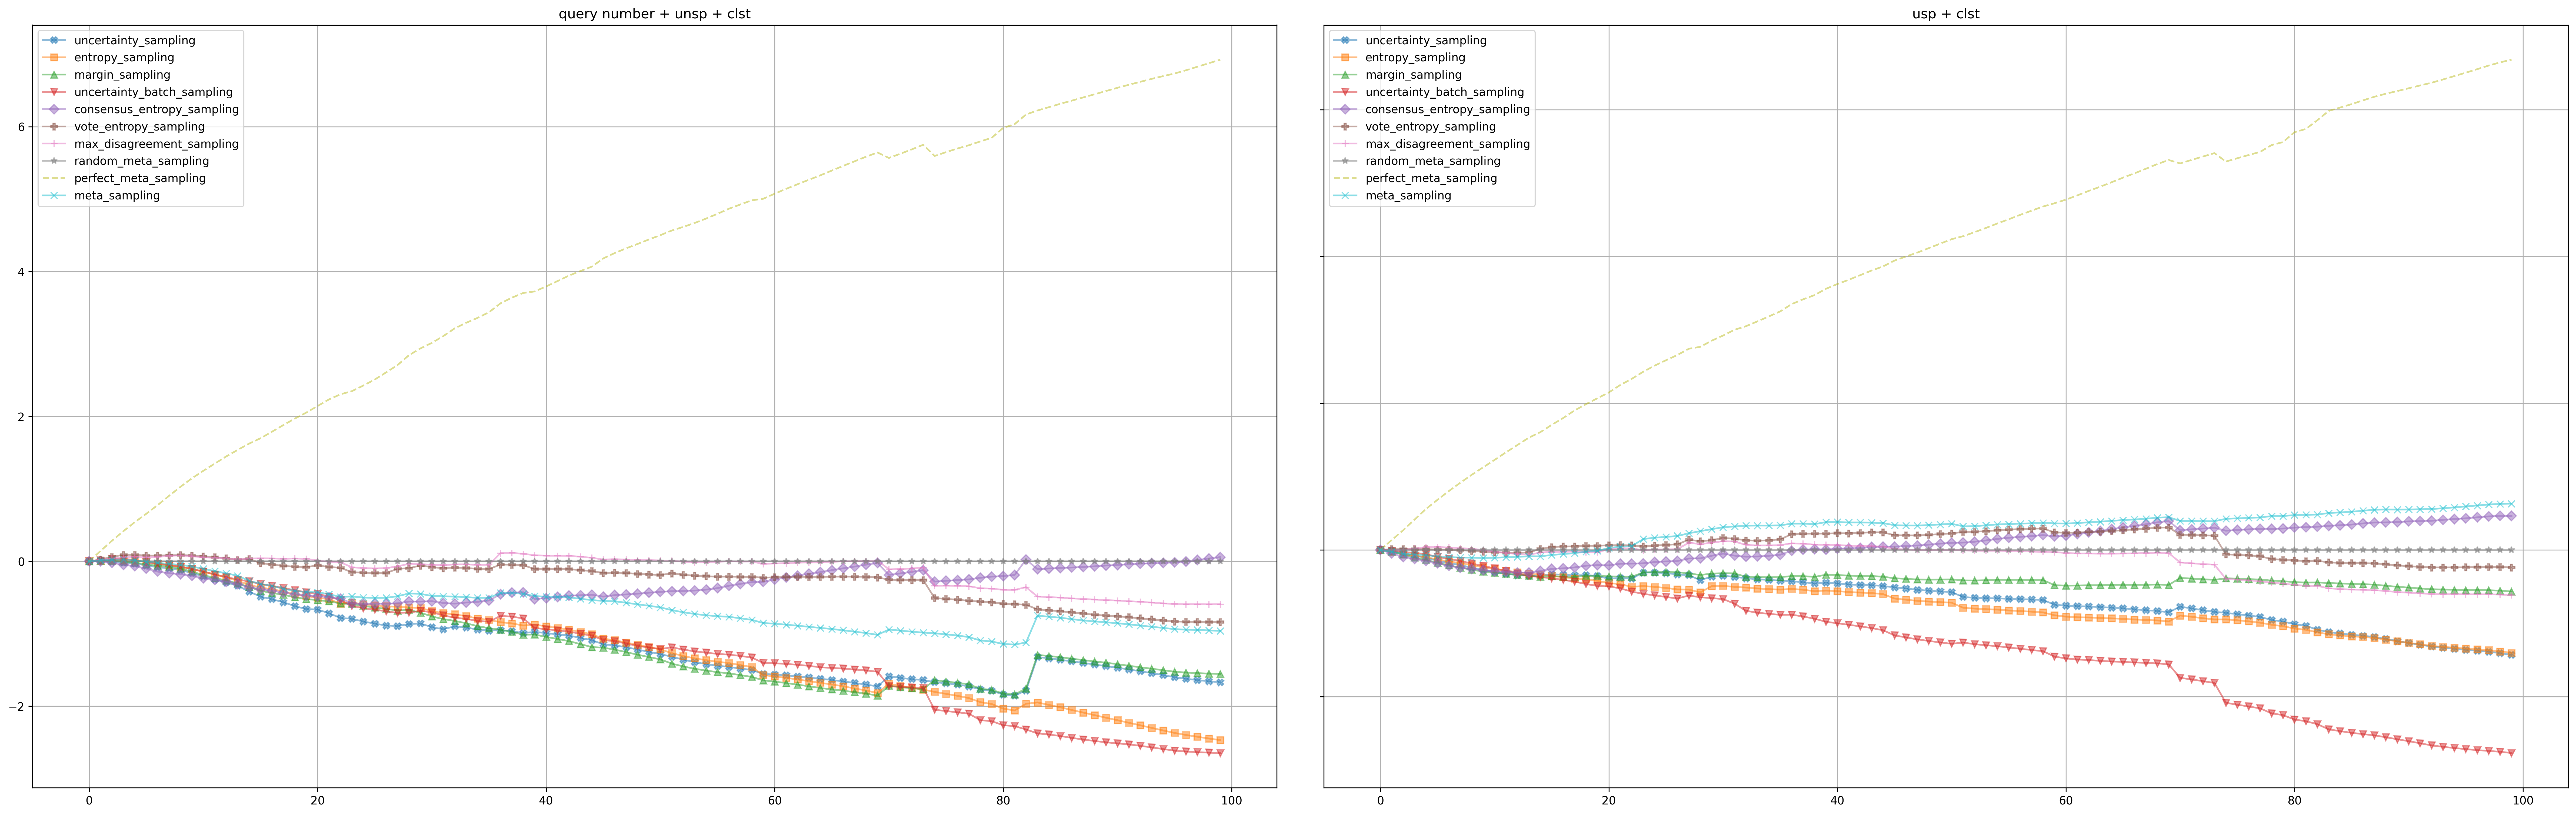

In [85]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(32,10)
fig.set_dpi(300)
fig.tight_layout()
summary_graph(old_svm_results, ax=axs[0], title='query number + unsp + clst')
summary_graph(svm_results, ax=axs[1], title='usp + clst')
plt.show()

### Analise Gráfica das Recomendações

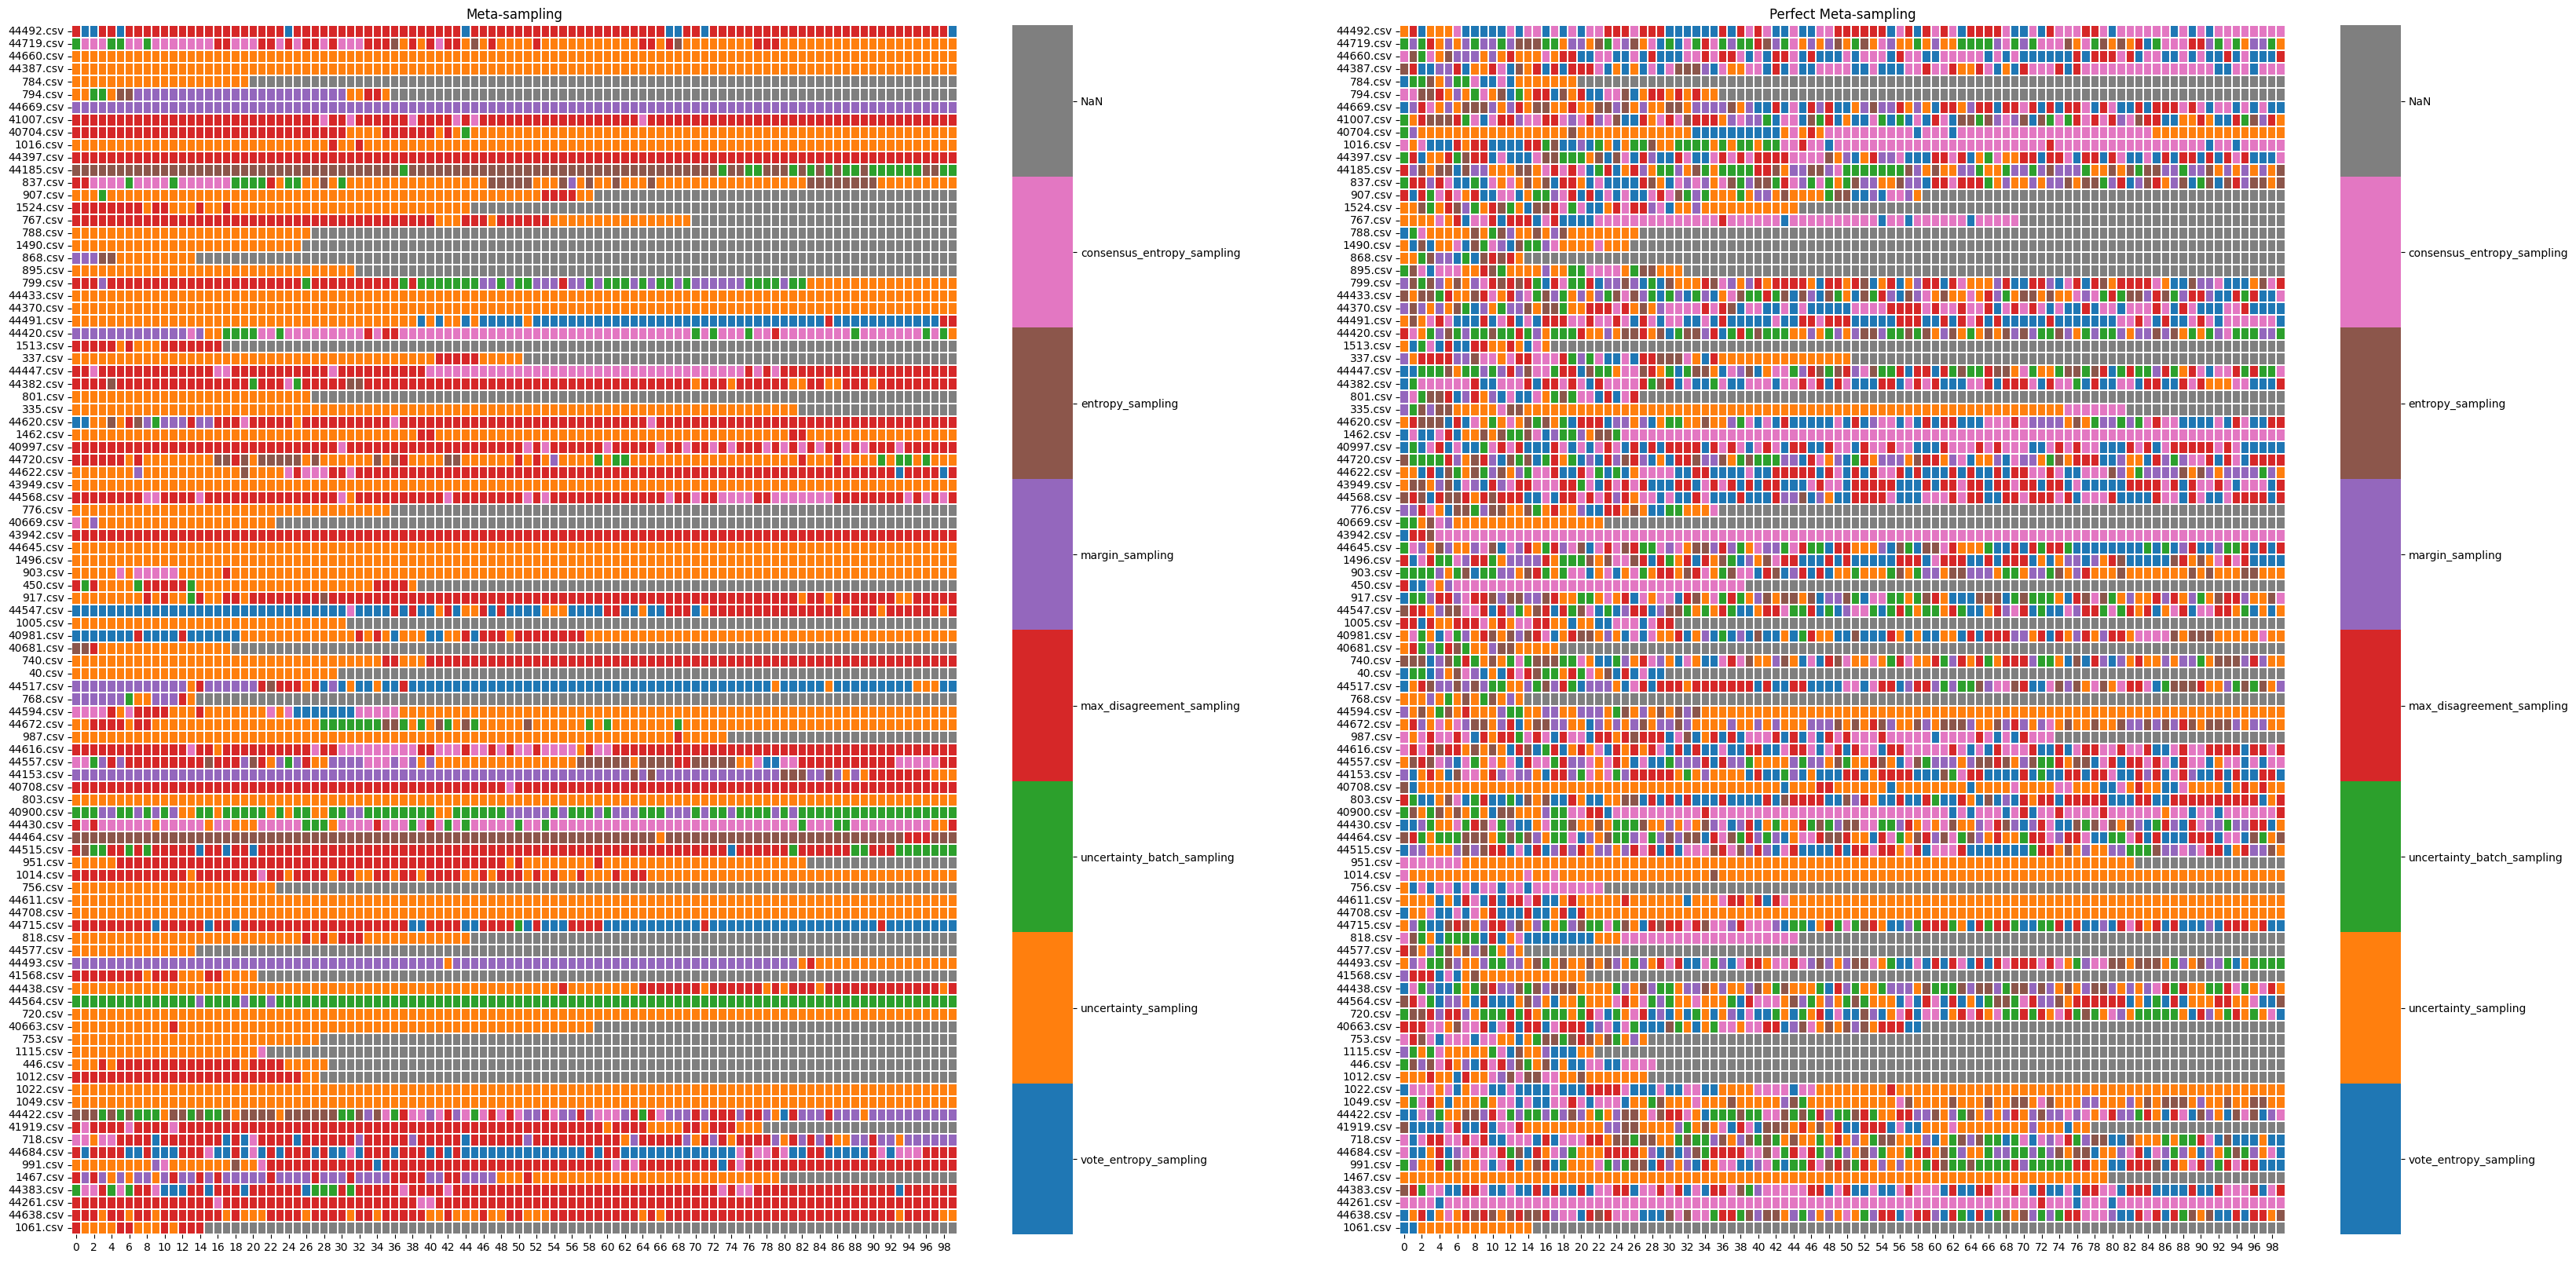

In [86]:
plot_heat_maps(svm_results)

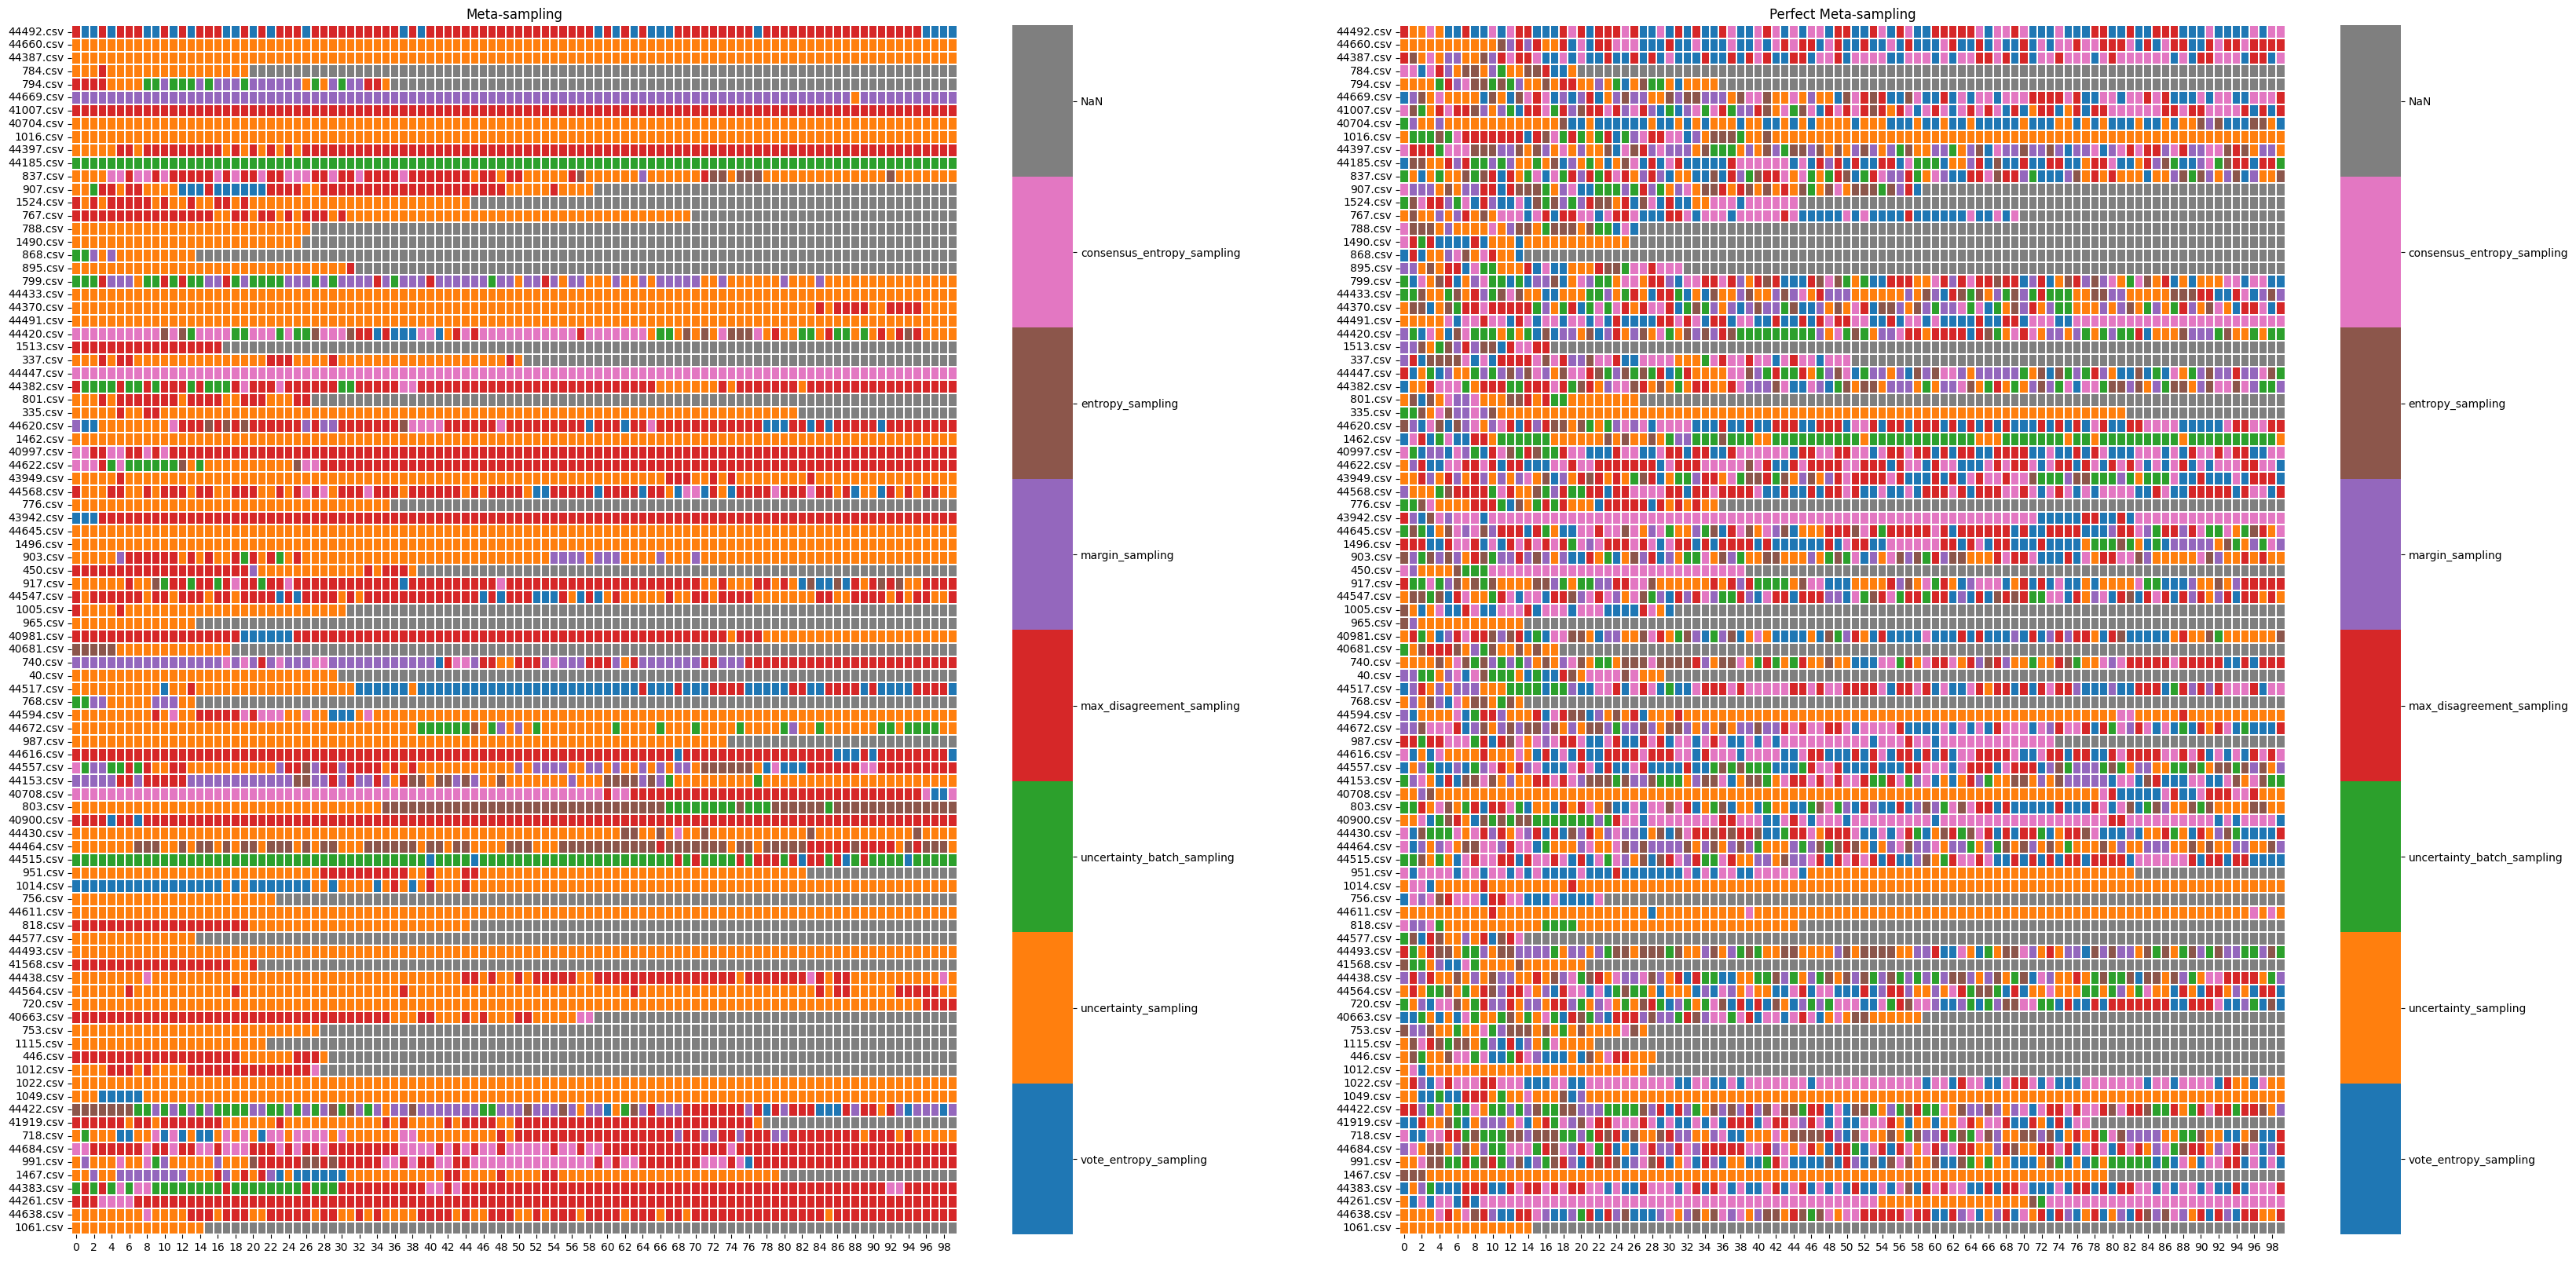

In [87]:
plot_heat_maps(old_svm_results)

### Análise descritiva das recomendações

In [88]:
describe_results(svm_results)

random_sampling_choice  perfect_sampling_choice  \
uncertainty_sampling                      0.140475                 0.239861   
max_disagreement_sampling                 0.149146                 0.151814   
margin_sampling                           0.144210                 0.081510   
consensus_entropy_sampling                0.146878                 0.200640   
vote_entropy_sampling                     0.132337                 0.157551   
uncertainty_batch_sampling                0.139007                 0.084178   
entropy_sampling                          0.147946                 0.084445   

                            meta_sampling_choice  
uncertainty_sampling                    0.448106  
max_disagreement_sampling               0.312567  
margin_sampling                         0.064568  
consensus_entropy_sampling              0.051494  
vote_entropy_sampling                   0.044557  
uncertainty_batch_sampling              0.041622  
entropy_sampling                        0.037086

In [89]:
describe_results(old_svm_results)

random_sampling_choice  perfect_sampling_choice  \
uncertainty_sampling                      0.142232                 0.238747   
max_disagreement_sampling                 0.145195                 0.160011   
consensus_entropy_sampling                0.133907                 0.189079   
margin_sampling                           0.142938                 0.083674   
uncertainty_batch_sampling                0.141809                 0.083251   
vote_entropy_sampling                     0.142232                 0.161563   
entropy_sampling                          0.151686                 0.083674   

                            meta_sampling_choice  
uncertainty_sampling                    0.493721  
max_disagreement_sampling               0.303372  
consensus_entropy_sampling              0.051644  
margin_sampling                         0.047693  
uncertainty_batch_sampling              0.047411  
vote_entropy_sampling                   0.029632  
entropy_sampling                        0.026527

## Random Forest Como Aprendiz

In [92]:
rf_results = !find $RESULTS_DIR -type f | grep 'RandomForestClassifier/'
old_rf_results = !find $RESULTS_DIR -type f | grep 'RandomForestClassifier_'

print(f'- {len(old_rf_results)} (query number + unsp. mfts + clst. mfts)')
print(f'- {len(rf_results)} (unsp. mfts + clst. mfts)')

- 68 (query number + unsp. mfts + clst. mfts)
- 91 (unsp. mfts + clst. mfts)


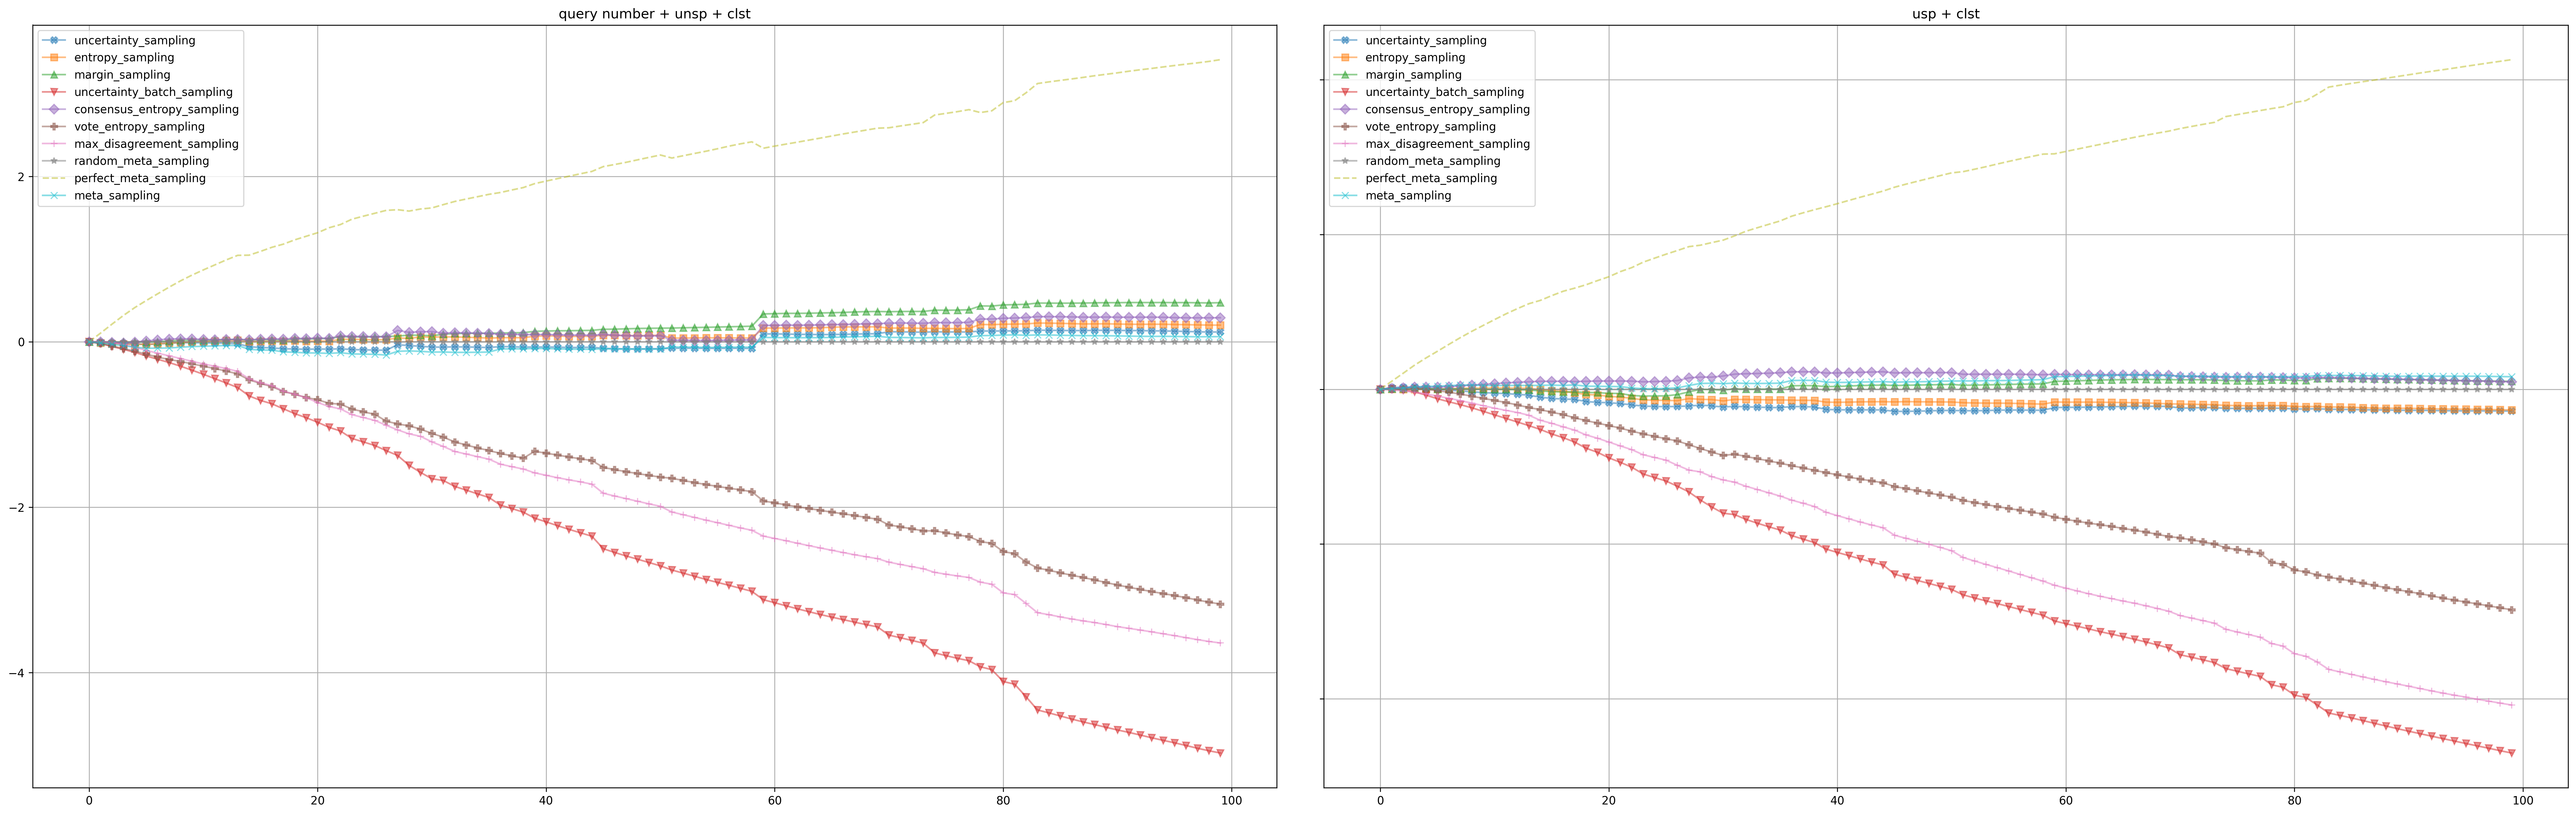

In [93]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(32,10)
fig.set_dpi(300)
fig.tight_layout()
summary_graph(old_rf_results, ax=axs[0], title='query number + unsp + clst')
summary_graph(rf_results, ax=axs[1], title='usp + clst')
plt.show()

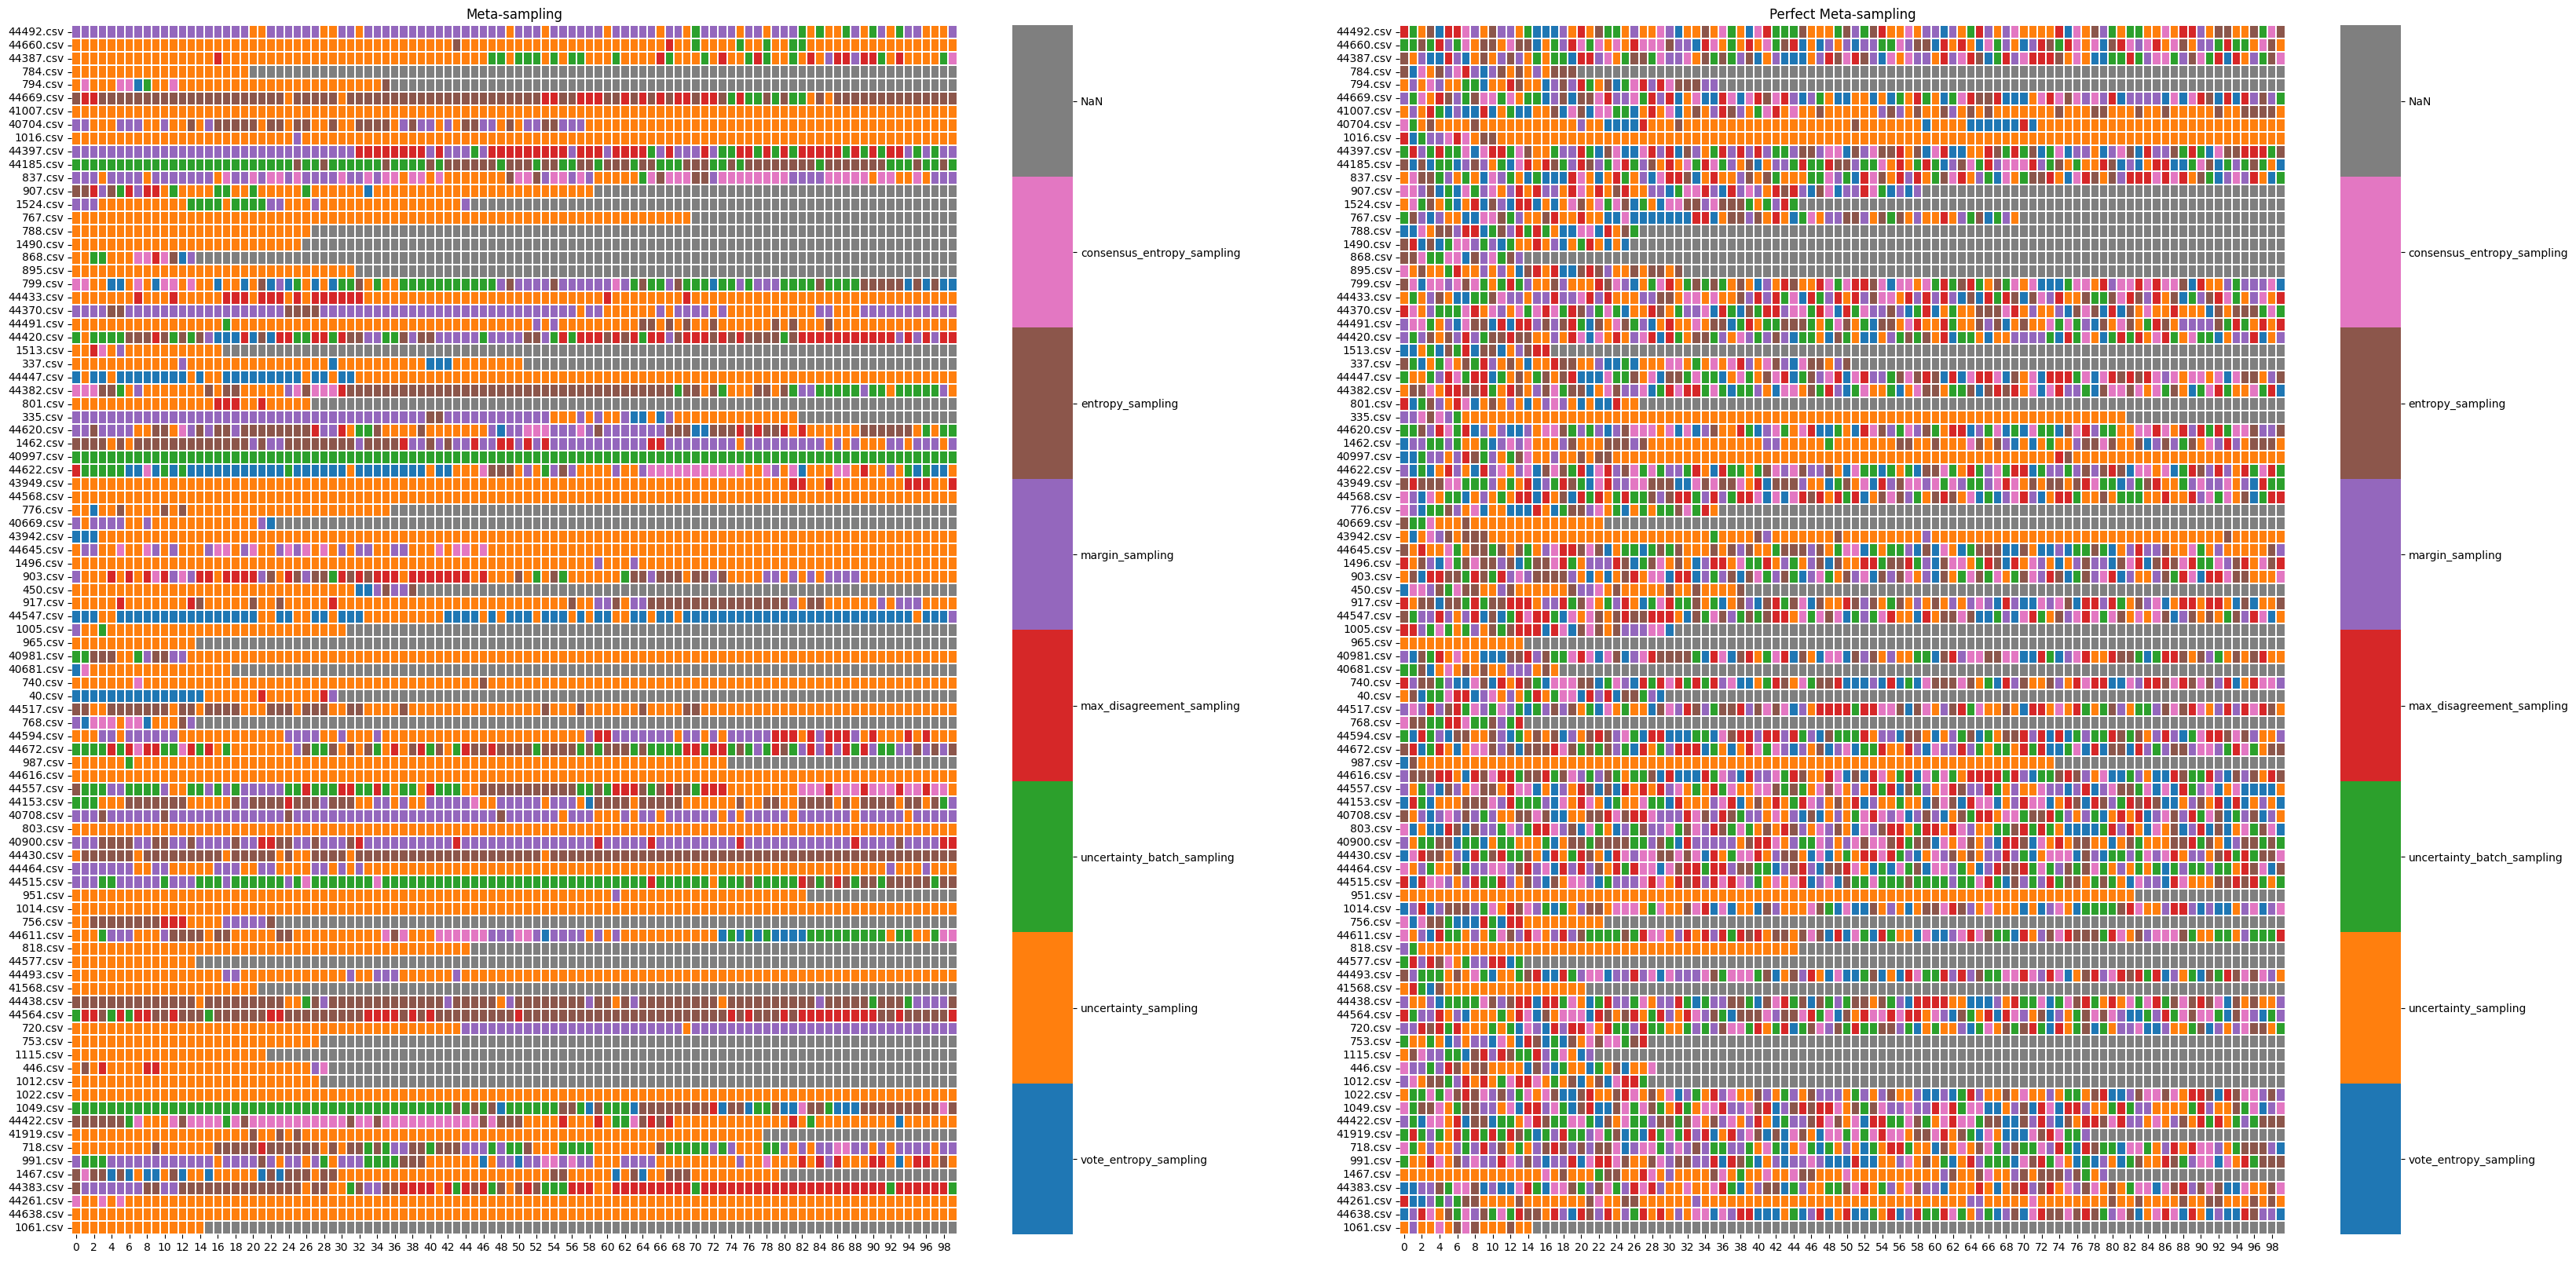

In [94]:
plot_heat_maps(rf_results)

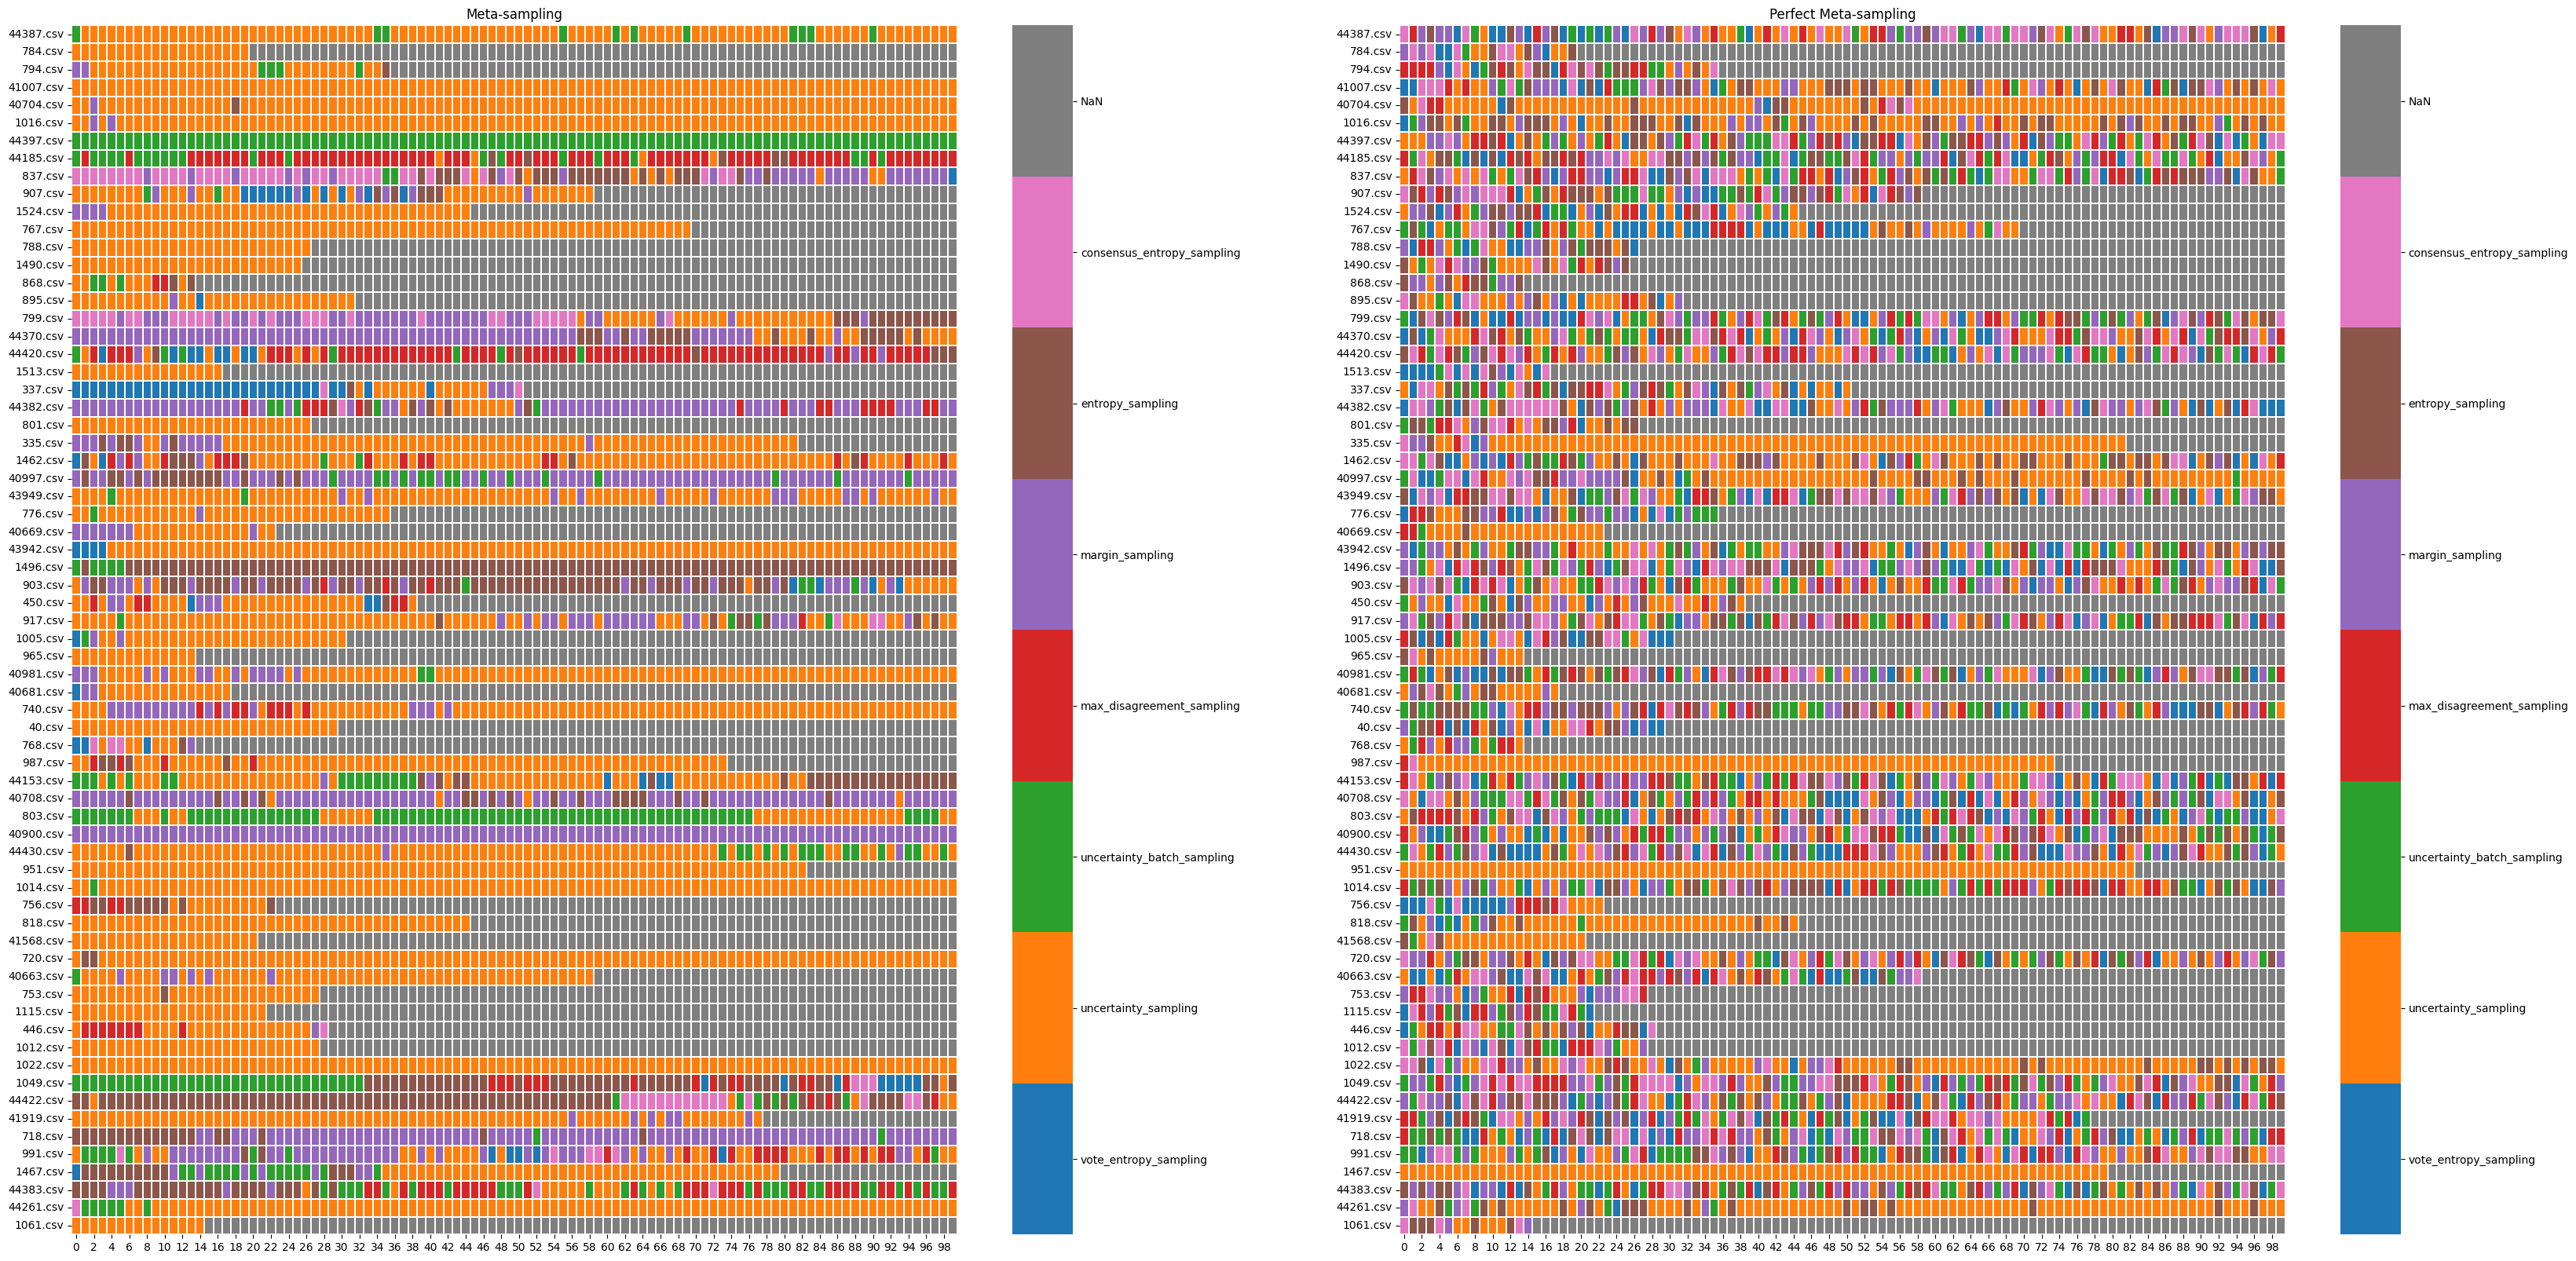

In [95]:
plot_heat_maps(old_rf_results)

#### Análise Descritiva

In [96]:
describe_results(rf_results)

random_sampling_choice  perfect_sampling_choice  \
uncertainty_sampling                      0.145159                 0.266868   
margin_sampling                           0.140411                 0.120558   
entropy_sampling                          0.140699                 0.144584   
uncertainty_batch_sampling                0.140124                 0.125737   
max_disagreement_sampling                 0.153072                 0.117537   
vote_entropy_sampling                     0.142713                 0.108474   
consensus_entropy_sampling                0.137822                 0.116242   

                            meta_sampling_choice  
uncertainty_sampling                    0.550137  
margin_sampling                         0.133650  
entropy_sampling                        0.128758  
uncertainty_batch_sampling              0.080996  
max_disagreement_sampling               0.048626  
vote_entropy_sampling                   0.032082  
consensus_entropy_sampling              0.025752

In [97]:
describe_results(old_rf_results)

random_sampling_choice  perfect_sampling_choice  \
uncertainty_sampling                      0.147785                 0.299191   
margin_sampling                           0.150128                 0.120741   
entropy_sampling                          0.138842                 0.150341   
uncertainty_batch_sampling                0.143101                 0.114353   
max_disagreement_sampling                 0.145230                 0.102853   
consensus_entropy_sampling                0.140119                 0.109029   
vote_entropy_sampling                     0.134796                 0.103492   

                            meta_sampling_choice  
uncertainty_sampling                    0.559199  
margin_sampling                         0.155664  
entropy_sampling                        0.104557  
uncertainty_batch_sampling              0.082836  
max_disagreement_sampling               0.056857  
consensus_entropy_sampling              0.021934  
vote_entropy_sampling                   0.018952